In [44]:
# from datetime import datetime
from IPython.display import display, Markdown
from datetime import datetime

todays_date = str(datetime.now().date())

display(Markdown("# Notebook - LogReg koefficient analysis"))
display(Markdown("Author: Lena Erlach"))
display(Markdown("Created: 2024-01-25"))
display(Markdown(f"Last modified: {todays_date}"))


import numpy as np
import pandas as pd
import os
import sys
import configparser
import random
from tqdm import tqdm

from matplotlib_venn import venn3, venn2

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

UTILS_DIR = "../../src/"
sys.path.append(UTILS_DIR)
import utils_nb as utils
import matplotlib.pyplot as plt

CONFIG_PATH = "../../config_file_GEX_BCR.txt"

# setup parser for the config file
config = configparser.ConfigParser()
config.read(CONFIG_PATH)
ROOT_DIR = config["ROOT"]["ROOT_DIR"]
UTILS_DIR = config["ROOT"]["UTILS_DIR"]
sys.path.append(UTILS_DIR)
sys.path.append(os.path.join(UTILS_DIR))

# add the path to the Specificity_classification_class
sys.path.append("../../src/Spec_classification/")


## Set output path for the plots/tables
plot_outPath = os.path.join(
    ROOT_DIR, "data/model_interpretation/Specificity_classification/"
)
# create the output path if it does not exist
if not os.path.exists(plot_outPath):
    os.makedirs(plot_outPath)

# Notebook - LogReg koefficient analysis

Author: Lena Erlach

Created: 2024-01-25

Last modified: 2024-08-20

In [45]:
############# CUSTOM FUNCTIONS ####################

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    matthews_corrcoef,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats
from statsmodels.stats.multitest import multipletests


#### Custom functions
def train_Model(model, X, y, model_name="LogReg"):
    # define the grid
    if model_name == "LogReg":
        grid = {
            "clf__penalty": ["l2", None],
            "clf__class_weight": ["balanced", None],
            "clf__C": [10, 1, 0.1, 0.01, 0.001],
            "clf__max_iter": [500, 1000, 2000],
        }   
    elif model_name == "Ridge":
        grid = {
            "clf__alpha": [0.1, 1, 10]
        }
        


    # define the pipeline
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", model)])

    # define the metrics
    metrics = {
        # "accuracy": accuracy_score,
        "f1": f1_score,
        "precision": precision_score,
        "recall": recall_score,
        "roc_auc": roc_auc_score,
        "matthews_corrcoef": matthews_corrcoef,
    }

    metrics_n = list(metrics.keys())

    # define the grid search with 5-fold cross validation
    grid_search = GridSearchCV(
        pipe, grid, cv=5, scoring=metrics_n, refit="f1", n_jobs=-1, verbose=0
    )

    # Find best parameters
    grid_search.fit(X, y)

    return grid_search


# plot ROC and the PR curve
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split


def roc_plots(X, y, best_model):
    # Assuming `X_test` is your test dataset and `model` is your trained model
    # split X into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123, stratify=y
    )

    trained_best_model = best_model.fit(X_train, y_train)

    # Step 1: Predict probabilities for the positive class
    y_scores = trained_best_model.predict_proba(X_test)[:, 1]

    # Step 2: Calculate precision and recall for various thresholds
    precision, recall, thresholds = precision_recall_curve(
        y_test, y_scores, pos_label=1
    )

    # Calculate the fpr and tpr for all thresholds of the classification (ROC Curve)
    fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_scores)

    # Step 3: Calculate AUC for the PR curve
    auc_pr = auc(recall, precision)

    # Step 4: Plot the PR curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    # Subplot 1: Precision-Recall Curve
    plt.plot(recall, precision, label=f"Precision-Recall curve (area = {auc_pr:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="best")

    # Subplot 2: ROC Curve
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(fpr, tpr, color="darkorange", label=f"ROC Curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()


def calculate_p_values(X, best_model, feature_coeffs):
    '''
    Calculate the p-values for the coefficients of the logistic regression model
    
    Parameters
    ----------
    X : np.array
        The feature matrix
    y : np.array
        The label vector
    best_model : sklearn.model
        The trained and best model pipeline from the grid search
    feature_coeffs : pd.DataFrame
        The dataframe with the gene names and coefficients of the model
    '''
    # Get the coefficients and intercept
    coefficients = best_model["clf"].coef_.flatten()

    # Calculate the standard errors (SE)
    # Calculate the covariance matrix of the coefficients
    cov_matrix = np.linalg.inv(np.dot(X.T, X))
    standard_errors = np.sqrt(np.diag(cov_matrix))

    # Calculate the z-scores
    z_scores = coefficients / standard_errors

    # Calculate the p-values from z-scores
    p_values = stats.norm.sf(abs(z_scores)) * 2  # two-tailed test

    # filter invalid p-values
    valid_p_values = p_values[~np.isnan(p_values)]

    # clip very small p-values
    epsilon = 1e-10
    valid_p_values_c = np.clip(valid_p_values, epsilon, 1 - epsilon)

    adjusted_p_values = multipletests(valid_p_values_c, method="fdr_bh")[1]

    # Create a DataFrame for coefficients and adjusted p-values
    results_df = pd.DataFrame(
        {
            "gene_names": feature_coeffs["gene_names"][~np.isnan(p_values)],
            "coefficients": feature_coeffs["coeff"][~np.isnan(p_values)],
            "valid_p_value": valid_p_values_c,
            "adjusted_p_value": adjusted_p_values,
        }
    )

    return results_df


def plot_correlation(vals1, vals2, datasets=["OVA", "RBD"], plot_outPath=None):
    # get the correlation of the genes
    correlation = pearsonr(vals1, vals2)

    # plot the correlation as scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(vals1, vals2, s=10)
    plt.xlabel(datasets[0])
    plt.ylabel(datasets[1])
    plt.title("Correlation of gene coefficients")
    # plot a line for the correlation that is a linear fit
    plt.plot(vals1, vals1 * correlation[0], color="red")
    # add the correlation coefficient
    plt.text(
        0.7,
        0.15,
        f"Pearson r:  {correlation[0]:.3f} \n p-val: {correlation[1]:.4}",
        fontsize=12,
        transform=plt.gcf().transFigure,
    )

    if plot_outPath is not None:
        plt.savefig(
            os.path.join(plot_outPath, f"correlation_{datasets[0]}_{datasets[1]}.png"),
            dpi=600,
        )
    plt.show()





import seaborn as sns
from matplotlib.collections import PolyCollection



def violin_custom(feature_df, pos_genes, num_genes=10, title_name="Gene expression of top 10 genes", save_path=None):
    custom_palette = "Set1"
    # melt the dataframe
    feature_df_melt = pd.melt(feature_df, id_vars='group_id', value_vars=pos_genes.gene_names.values[:num_genes])
    # rename columns
    feature_df_melt.columns = ['group_id', 'gene_name', 'Expression']
    feature_df_melt['group_id'] = feature_df_melt['group_id'].replace({1: 'Specific', 2: 'Non-specific'})


    plt.figure(figsize=(18, 6))
    ax = sns.violinplot(data=feature_df_melt, x='gene_name', y='Expression', hue='group_id', palette=custom_palette, linewidth=0.85)
    plt.title(title_name)
    
    # Remove borders by setting edge color to face color
    for violin in ax.collections:
        if isinstance(violin, PolyCollection):
            violin.set_edgecolor(violin.get_facecolor())
    
    # save plot
    if save_path is not None:
        plt.savefig(save_path, dpi=600)

    plt.show()


def violin_plot_sign(feature_df, genes, save_path=None): 
    # melt the dataframe
    feature_df_melt = pd.melt(feature_df, id_vars='group_id', value_vars=genes)
    # rename columns
    feature_df_melt.columns = ['group_id', 'gene_name', 'Expression']
    feature_df_melt['group_id'] = feature_df_melt['group_id'].replace({1: 'Specific', 2: 'Non-specific'})



    df = feature_df_melt[feature_df_melt['gene_name'].isin(genes)]


    # Create the violin plot
    plt.figure(figsize=(15, 6))
    ax = sns.violinplot(x='gene_name', y='Expression', hue='group_id', data=df, palette="Set1", linewidth=0.85)

    # Remove borders by setting edge color to face color
    for violin in ax.collections:
        if isinstance(violin, PolyCollection):
            violin.set_edgecolor(violin.get_facecolor())

    # # Example of calculating p-values and annotating them
    # # Here, I'll show you how to calculate the p-value for each pair of genes within the same group
    gene_list = df['gene_name'].unique()
    p_values = []



    for gene in gene_list:
        group_specific = df[(df['gene_name'] == gene) & (df['group_id'] == 'Specific')]['Expression']
        group_nonspecific = df[(df['gene_name'] == gene) & (df['group_id'] == 'Non-specific')]['Expression']
        
        # Perform Welch's t-test
        stat, p_value = ttest_ind(group_specific, group_nonspecific, equal_var=False)  # Welch's t-test
        p_values.append(p_value)


    adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

    # Annotate the plot with stars for significance levels
    significance_levels = {0.001: '***', 0.01: '**', 0.05: '*'}
    for i, (gene, adj_p_value) in enumerate(zip(gene_list, adjusted_p_values)):
        for level, symbol in significance_levels.items():
            if adj_p_value < level:
                x = ax.get_xticks()[i]
                y = df[df['gene_name'] == gene]['Expression'].max() + 0.4
                ax.text(x, y, symbol, ha='center', va='bottom', color='black', fontsize=12)
                break  # Move on to the next gene once the highest significance level is found


    plt.title('Gene Expression Comparison with Significance')
    plt.xlabel('Gene')
    plt.ylabel('Expression')
    plt.title('Gene Expression Comparison with Significance')
    plt.xlabel('Gene')
    plt.ylabel('Expression')

    if save_path is not None:
        plt.savefig(save_path, dpi=600)

    plt.show()






# set random seed
random.seed(123)

In [46]:
################## SETUP ##################
ab_chain = "VDJ_VJ_aaSeq"

if ab_chain == "VDJ_aaSeq":
    c_type = "VH"
elif ab_chain == "VDJ_VJ_aaSeq":
    c_type = "VH_VL"

datasets = ["OVA", "RBD", "INTEGRATED"]


# number of genes to investigate
num_genes = 50

In [47]:
################## LOAD DATA - OVA ##################
dataset = datasets[0]

# dataset = 'INTEGRATED'
feat_inputPath = os.path.join(ROOT_DIR, config["BCR_GEX"][dataset])

# Load dataframe
feature_df = pd.read_csv(feat_inputPath)


#### Prepare datasets
GEX = feature_df.iloc[:, -2000:].values
kmer = feature_df.iloc[:, 6:-2000].values
GEX_kmer = feature_df.iloc[:, 6:].values
y = feature_df.loc[:, "group_id"].values
y = [0 if i == 2 else i for i in y]
y = np.array(y)

X = GEX

/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

F1: 0.809 +/- 0.066
Pr: 0.808 +/- 0.129
Rec: 0.841 +/- 0.101
ROC AUC: 0.978 +/- 0.004
MCC: 0.794 +/- 0.063


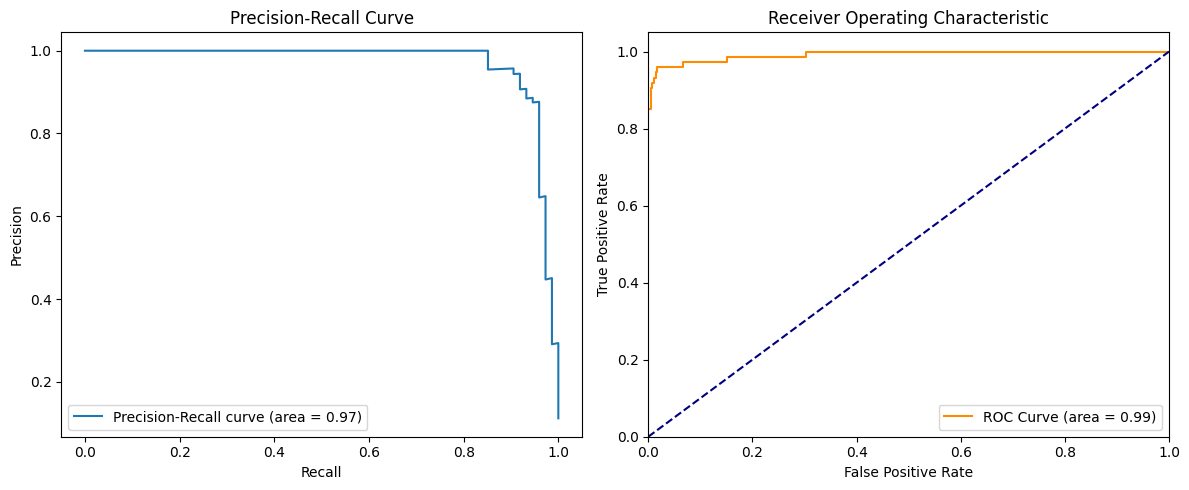

{'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__max_iter': 500, 'clf__penalty': 'l2'}
Best score F1: 0.88


In [48]:
####### Train model
# define the model
model = LogisticRegression(random_state=123)

grid_search = train_Model(model, X=X, y=y)

# best model
best_model = grid_search.best_estimator_

# get the best scores
print(
    f'F1: {np.mean(grid_search.cv_results_["mean_test_f1"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_f1"]):.3f}'
)
print(
    f'Pr: {np.mean(grid_search.cv_results_["mean_test_precision"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_precision"]):.3f}'
)
print(
    f'Rec: {np.mean(grid_search.cv_results_["mean_test_recall"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_recall"]):.3f}'
)
print(
    f'ROC AUC: {np.mean(grid_search.cv_results_["mean_test_roc_auc"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_roc_auc"]):.3f}'
)
print(
    f'MCC: {np.mean(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f}'
)

## Plot ROC curves
roc_plots(X=GEX, y=y, best_model=best_model)

# print best parameters and score
print(grid_search.best_params_)
print(f"Best score F1: {np.round(grid_search.best_score_, 4)}")

# summarize in dataframe
feature_coeffs = pd.DataFrame(
    best_model["clf"].coef_.T,
    index=range(len(best_model["clf"].coef_[0])),
    columns=["coeff"],
)
feature_coeffs["gene_names"] = feature_df.columns[-2000:]

### 1. Calculate P-val from the sklearn model (OVA) 

Select genes with coefficients significantly different to the mean of the coefficients

In [49]:
# calculate p-values
results_df = calculate_p_values(X, best_model, feature_coeffs)

# Now you can filter based on your p-value threshold, e.g., 0.05
significant_genes = results_df[results_df['adjusted_p_value'] < 0.05]

#### Create a dictinary of significant genes for all the datasets 
significant_genes_list = {}
significant_genes_list["OVA"] = significant_genes


#### Create a dictinary of significant genes for all the datasets 
significant_genes_list = {}
significant_genes_list["OVA"] = significant_genes

# print(significant_genes_list["OVA"].gene_names.values)

/tmp/ipykernel_991209/31541183.py:141: RuntimeWarning: invalid value encountered in sqrt
  standard_errors = np.sqrt(np.diag(cov_matrix))


In [50]:
# plt.hist(significant_genes['coefficients'], bins=50)
# plt.title("Coefficients of significant genes")
# plt.ylim(0, 380)
# plt.show()
# plt.hist(feature_coeffs['coeff'], bins=50)
# plt.title("Coefficients of all genes")
# plt.ylim(0, 380)
# plt.show()

### 2. Sort genes and take top 50 genes

/tmp/ipykernel_991209/2170630214.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_genes.loc[:, "significant"] = pos_genes["gene_names"].isin(significant_genes_list[dataset]["gene_names"])
/tmp/ipykernel_991209/2170630214.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_genes.loc[:, "significant"] = neg_genes["gene_names"].isin(significant_genes_list[dataset]["gene_names"])


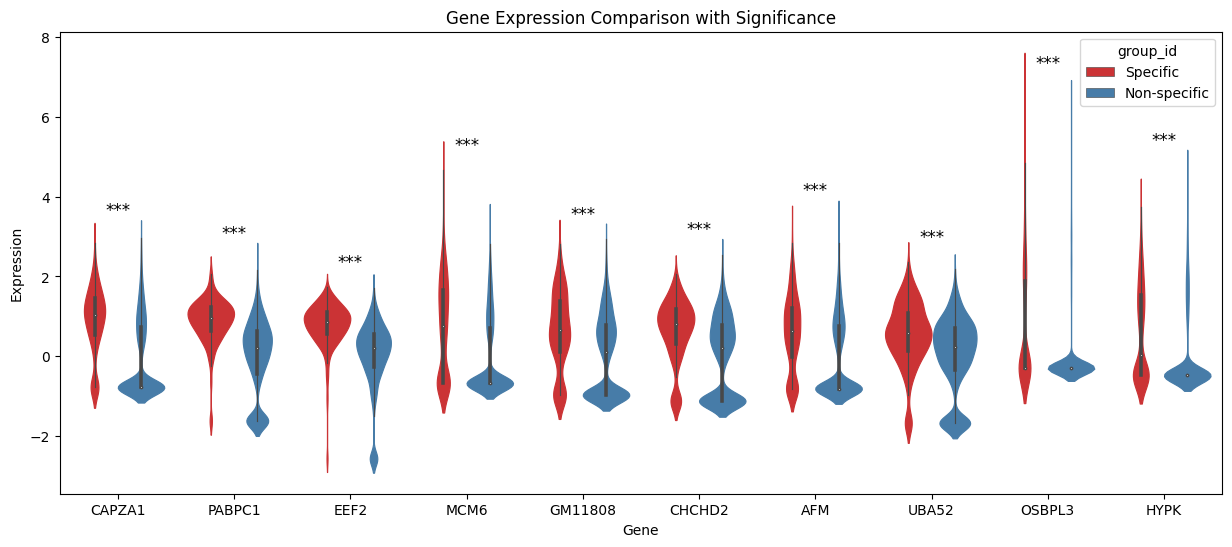

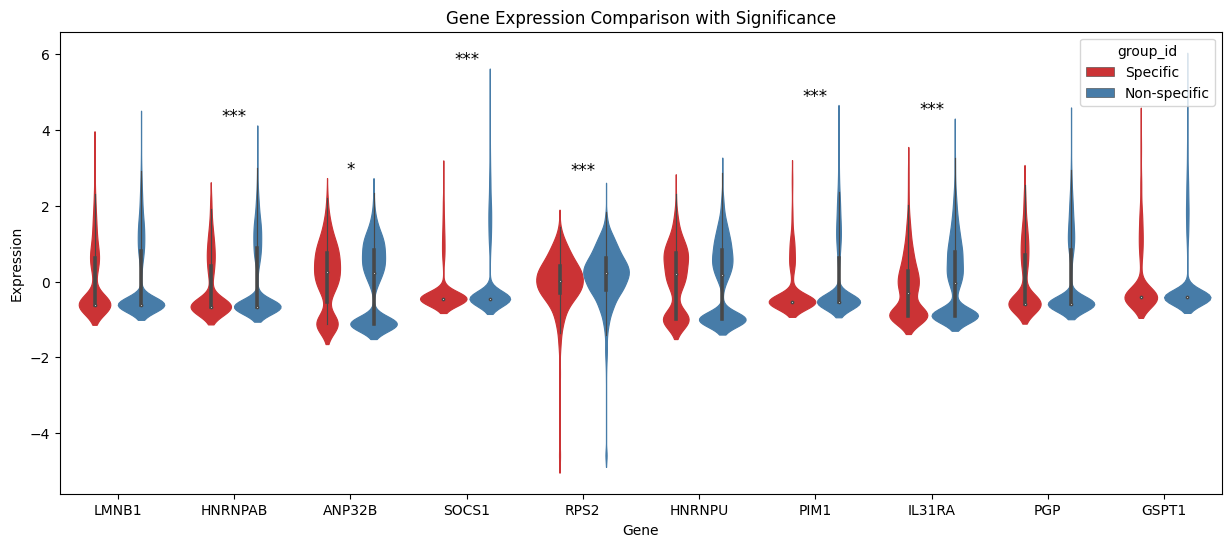

         coeff gene_names  significant
334   0.619784     CAPZA1         True
1574  0.546699     PABPC1         True
1094  0.537050       EEF2         True
68    0.405812       MCM6         True
372   0.383614    GM11808         True
576   0.323889     CHCHD2         True
536   0.319263        AFM         True
860   0.311528      UBA52         True
622   0.300307     OSBPL3         True
214   0.291843       HYPK         True
         coeff gene_names  significant
1839 -0.325610      LMNB1         True
1182 -0.322063    HNRNPAB         True
398  -0.277299     ANP32B         True
1648 -0.275625      SOCS1         True
1737 -0.261429       RPS2         True
122  -0.248508     HNRNPU         True
1749 -0.245838       PIM1         True
1484 -0.237193     IL31RA         True
1736 -0.233742        PGP         True
1653 -0.229509      GSPT1         True


In [52]:
# get top and bottom genes
sorted_genes = feature_coeffs.sort_values(by="coeff", ascending=False)
pos_genes = sorted_genes[:num_genes]
neg_genes = sorted_genes[-num_genes:]

# add bool if gene is significant
pos_genes.loc[:, "significant"] = pos_genes["gene_names"].isin(significant_genes_list[dataset]["gene_names"])
neg_genes.loc[:, "significant"] = neg_genes["gene_names"].isin(significant_genes_list[dataset]["gene_names"])

all_genes = {dataset: feature_coeffs}
gene_dict = {dataset: [pos_genes, neg_genes]}
# print top 10 up and down coefficients
# print(pos_genes.gene_names.values)
# print(neg_genes.gene_names.values)

# Create the paired violin plot of the top significant genes
# violin_custom(feature_df, pos_genes[pos_genes.significant], num_genes=10, title_name="Gene expression of top 10 genes", save_path=os.path.join(plot_outPath, f'violin_top_genes10_{dataset}.png'))

save_path1 = os.path.join(plot_outPath, f'violin_sign_top_genes10_{dataset}.png')
save_path2 = os.path.join(plot_outPath, f'violin_sign_bottom_genes10_{dataset}.png')
# save_path1 = None
# save_path2 = None

violin_plot_sign(feature_df, genes=pos_genes.gene_names.values[:10], save_path=save_path1)
violin_plot_sign(feature_df, genes=neg_genes.sort_values(by="coeff", ascending=True).gene_names.values[:10], save_path=save_path2)

# prnt positive genes' signinficance level
print(pos_genes[:10])
print(neg_genes.sort_values(by="coeff", ascending=True)[:10])



# # plot the coefficients
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_coeffs)), feature_coeffs["coeff"])

# plt.xlabel("Feature")
# plt.ylabel("Coefficient")
# plt.title("Feature coefficients")
# plt.show()



### REPEAT for RBD

In [37]:
################## LOAD DATA - RBD ##################

dataset = datasets[1]
# dataset = 'INTEGRATED'
feat_inputPath = os.path.join(ROOT_DIR, config["BCR_GEX"][dataset])

# Load dataframe
feature_df = pd.read_csv(feat_inputPath)


#### Prepare datasets
GEX = feature_df.iloc[:, -2000:].values
kmer = feature_df.iloc[:, 6:-2000].values
GEX_kmer = feature_df.iloc[:, 6:].values
y = feature_df.loc[:, "group_id"].values
y = [0 if i == 2 else i for i in y]
y = np.array(y)
X = GEX

/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

F1: 0.917 +/- 0.033
Pr: 0.905 +/- 0.086
Rec: 0.939 +/- 0.042
ROC AUC: 0.993 +/- 0.002
MCC: 0.899 +/- 0.040


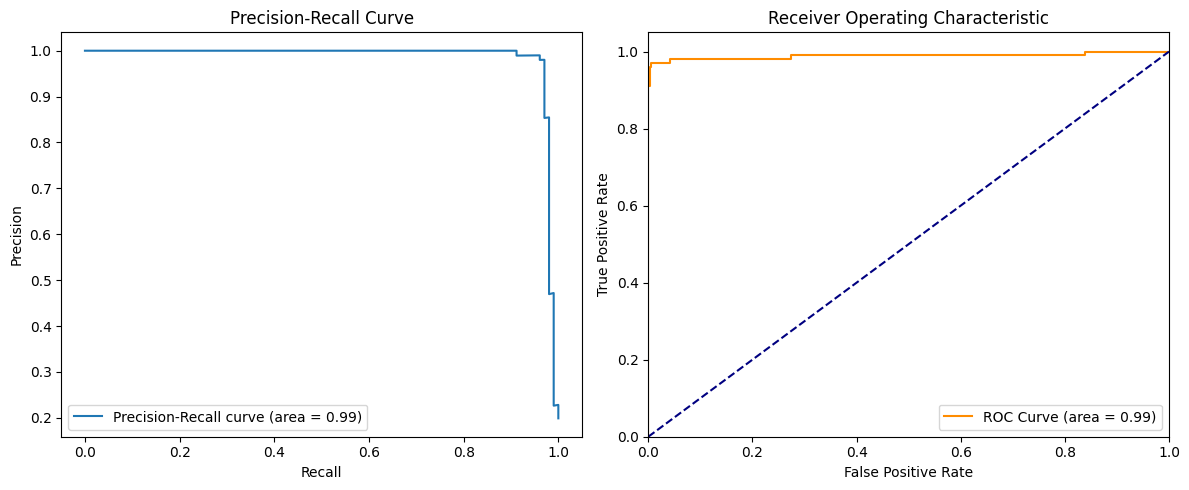

In [38]:
####### Train model

# define the model
model = LogisticRegression(random_state=123)

grid_search = train_Model(model, X=X, y=y)

# best model
best_model = grid_search.best_estimator_

# get the best scores
print(
    f'F1: {np.mean(grid_search.cv_results_["mean_test_f1"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_f1"]):.3f}'
)
print(
    f'Pr: {np.mean(grid_search.cv_results_["mean_test_precision"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_precision"]):.3f}'
)
print(
    f'Rec: {np.mean(grid_search.cv_results_["mean_test_recall"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_recall"]):.3f}'
)
print(
    f'ROC AUC: {np.mean(grid_search.cv_results_["mean_test_roc_auc"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_roc_auc"]):.3f}'
)
print(
    f'MCC: {np.mean(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f}'
)

## Plot ROC curves
roc_plots(X=X, y=y, best_model=best_model)

# summarize in dataframe
feature_coeffs = pd.DataFrame(
    best_model["clf"].coef_.T,
    index=range(len(best_model["clf"].coef_[0])),
    columns=["coeff"],
)
feature_coeffs["gene_names"] = feature_df.columns[-2000:]

### 1. Calculate P-val from the sklearn model (RBD)

--- preferred option for the selection of most significant genes from the LogReg

In [39]:
# calculate p-values
results_df = calculate_p_values(X, best_model, feature_coeffs)

# Now you can filter based on your p-value threshold, e.g., 0.05
significant_genes = results_df[results_df['adjusted_p_value'] < 0.05]

# Add to dictinary of significant genes for all the datasets 
significant_genes_list[dataset] = significant_genes

# print(significant_genes.gene_names.values)

/tmp/ipykernel_991209/31541183.py:141: RuntimeWarning: invalid value encountered in sqrt
  standard_errors = np.sqrt(np.diag(cov_matrix))


In [40]:
# plt.hist(significant_genes['coefficients'], bins=50)
# plt.title("Coefficients of significant genes")
# # plt.ylim(0, 380)
# plt.show()
# plt.hist(feature_coeffs['coeff'], bins=50)
# plt.title("Coefficients of all genes")
# # plt.ylim(0, 380)
# plt.show()

### 2. Sort genes and take top 50 genes

In [41]:
neg_genes.sort_values(by="coeff", ascending=False).gene_names.values[:10]

array(['GOT2', 'SLC25A5', 'CMSS1', 'EEF1G', 'APOE', 'TRIM37', 'PTGES3',
       'XLR3A', 'FXN', 'CENPX'], dtype=object)

/tmp/ipykernel_991209/2746037540.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_genes.loc[:, "significant"] = pos_genes["gene_names"].isin(significant_genes_list[dataset]["gene_names"])
/tmp/ipykernel_991209/2746037540.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_genes.loc[:, "significant"] = neg_genes["gene_names"].isin(significant_genes_list[dataset]["gene_names"])


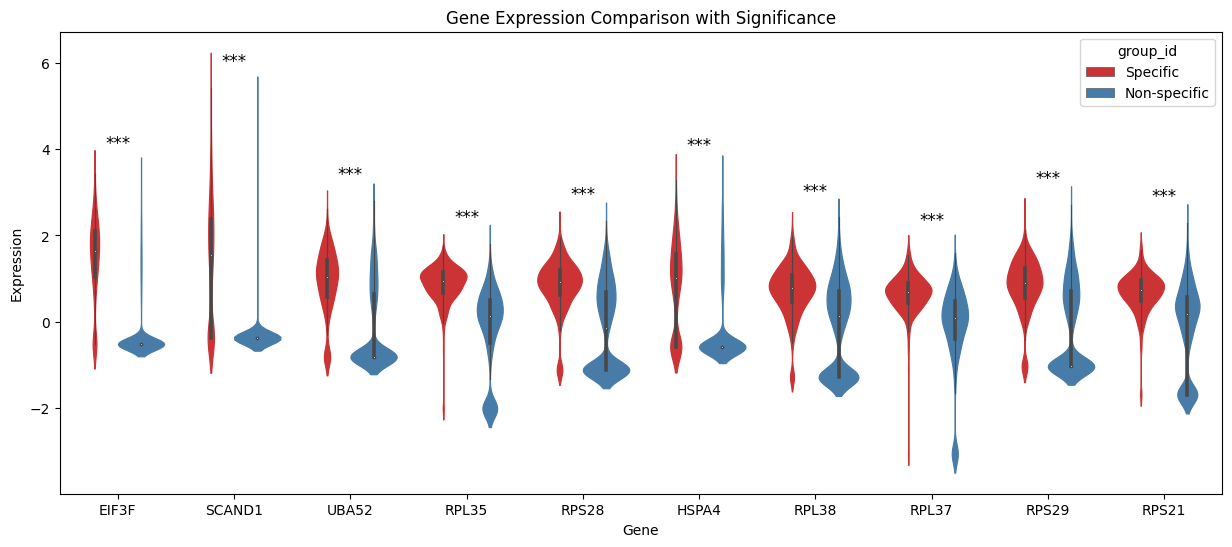

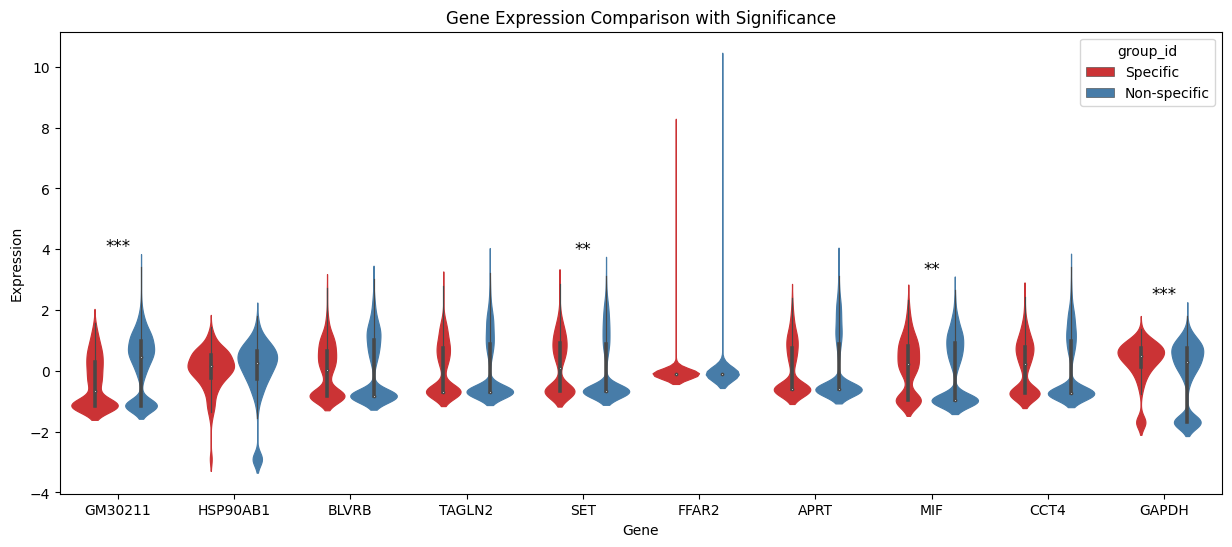

         coeff gene_names  significant
801   0.393266      EIF3F         True
244   0.308775     SCAND1         True
869   0.266557      UBA52         True
160   0.240518      RPL35         True
1762  0.204283      RPS28         True
1213  0.203927      HSPA4         True
1316  0.200617      RPL38         True
1584  0.199263      RPL37         True
1357  0.196948      RPS29         True
262   0.195636      RPS21         True
         coeff gene_names  significant
622  -0.153581    GM30211         True
1786 -0.100364   HSP90AB1        False
734  -0.089400      BLVRB        False
101  -0.070275     TAGLN2        False
149  -0.060307        SET        False
744  -0.059020      FFAR2        False
928  -0.054857       APRT        False
1091 -0.053926        MIF        False
1188 -0.052803       CCT4        False
665  -0.052150      GAPDH        False


In [43]:
# get top and bottom 20 genes
sorted_genes = feature_coeffs.sort_values(by="coeff", ascending=False)
pos_genes = sorted_genes[:num_genes]
neg_genes = sorted_genes[-num_genes:]

gene_dict[dataset] = [pos_genes, neg_genes]
all_genes[dataset] = feature_coeffs

# add bool if gene is significant
pos_genes.loc[:, "significant"] = pos_genes["gene_names"].isin(significant_genes_list[dataset]["gene_names"])
neg_genes.loc[:, "significant"] = neg_genes["gene_names"].isin(significant_genes_list[dataset]["gene_names"])

# Create the paired violin plot of the top significant genes
save_path1 = os.path.join(plot_outPath, f'violin_sign_top_genes10_{dataset}.png')
save_path2 = os.path.join(plot_outPath, f'violin_sign_bottom_genes10_{dataset}.png')

violin_plot_sign(feature_df, genes=pos_genes.gene_names.values[:10], save_path=os.path.join(plot_outPath, f'violin_sign_top_genes10_{dataset}.png'))
violin_plot_sign(feature_df, genes=neg_genes.sort_values(by="coeff", ascending=True).gene_names.values[:10], save_path=os.path.join(plot_outPath, f'violin_sign_bottom_genes10_{dataset}.png'))


# prnt positive genes' signinficance level
print(pos_genes[:10])
print(neg_genes.sort_values(by="coeff", ascending=True)[:10])


# # plot the coefficients
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_coeffs)), feature_coeffs["coeff"])

# plt.xlabel("Feature")
# plt.ylabel("Coefficient")
# plt.title("Feature coefficients")
# plt.show()

### INTEGRATED DATASET

In [53]:
################## LOAD DATA - INT ##################

dataset = datasets[2]

feat_inputPath = os.path.join(ROOT_DIR, config["BCR_GEX"][dataset])

# Load dataframe
feature_df = pd.read_csv(feat_inputPath)



#### Prepare datasets
GEX = feature_df.iloc[:, -2000:].values
kmer = feature_df.iloc[:, 6:-2000].values
GEX_kmer = feature_df.iloc[:, 6:].values
y = feature_df.loc[:, "group_id"].values
y = [0 if i == 2 else i for i in y]
y = np.array(y)

X = GEX

/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/data/cb/scratch/lenae/software/Anaconda/envs/abmap/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

F1: 0.193 +/- 0.040
Pr: 0.172 +/- 0.007
Rec: 0.248 +/- 0.064
ROC AUC: 0.524 +/- 0.005
MCC: 0.030 +/- 0.007


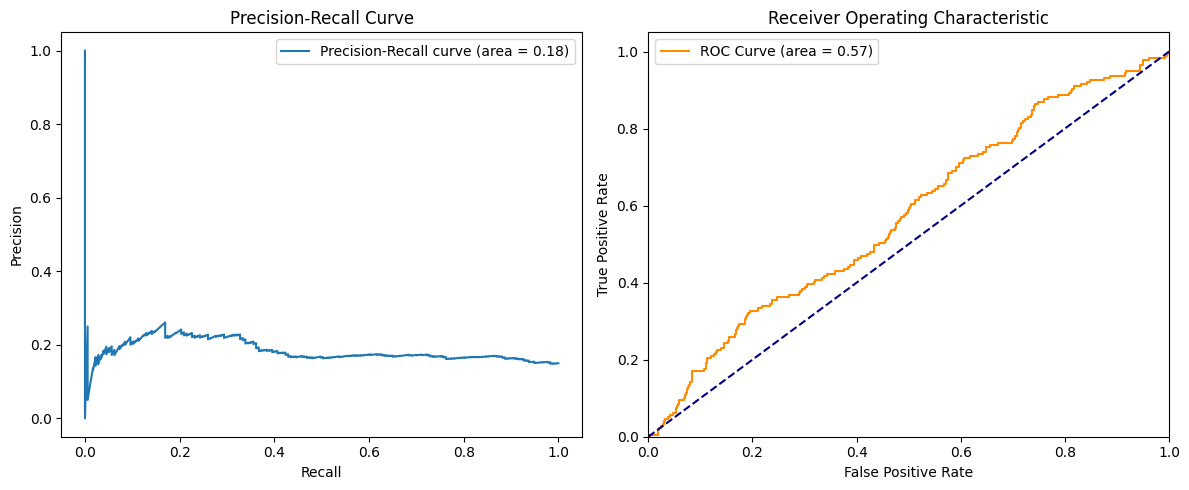

In [54]:
####### Train model

# define the model
model = LogisticRegression(random_state=123)

grid_search = train_Model(model, X=X, y=y)

# best model
best_model = grid_search.best_estimator_
# get the best scores
print(
    f'F1: {np.mean(grid_search.cv_results_["mean_test_f1"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_f1"]):.3f}'
)
print(
    f'Pr: {np.mean(grid_search.cv_results_["mean_test_precision"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_precision"]):.3f}'
)
print(
    f'Rec: {np.mean(grid_search.cv_results_["mean_test_recall"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_recall"]):.3f}'
)
print(
    f'ROC AUC: {np.mean(grid_search.cv_results_["mean_test_roc_auc"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_roc_auc"]):.3f}'
)
print(
    f'MCC: {np.mean(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f} +/- {np.std(grid_search.cv_results_["mean_test_matthews_corrcoef"]):.3f}'
)

## Plot ROC curves
roc_plots(X=X, y=y, best_model=best_model)

# summarize in dataframe
feature_coeffs = pd.DataFrame(
    best_model["clf"].coef_.T,
    index=range(len(best_model["clf"].coef_[0])),
    columns=["coeff"],
)
feature_coeffs["gene_names"] = feature_df.columns[-2000:]

### 1. Calculate P-val from the sklearn model (INT)

P value cannot be calculated because it results in a Singular matrix;  

In [47]:
# # # calculate p-values
# # results_df = calculate_p_values(X, best_model, feature_coeffs)
# results_df = calculate_p_values(X, best_model, feature_coeffs)

# # Now you can filter based on your p-value threshold, e.g., 0.05
# significant_genes = results_df[results_df['adjusted_p_value'] < 0.05]

# # Add to dictinary of significant genes for all the datasets 
# significant_genes_list["INT"] = significant_genes

# print(significant_genes.gene_names.values)


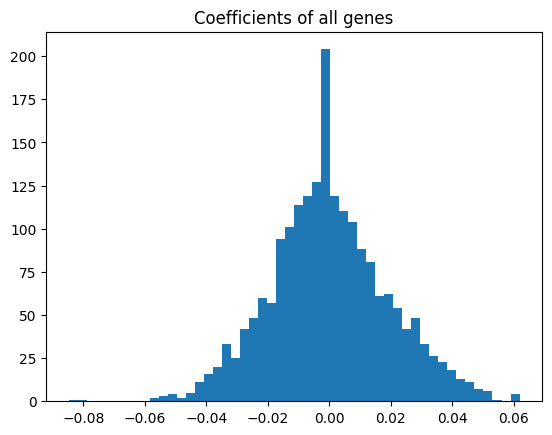

In [16]:
# plt.hist(feature_coeffs['coeff'], bins=50)
# plt.title("Coefficients of all genes")
# # plt.ylim(0, 380)
# plt.show()

### 2. Sort genes and take top 50 genes

['RPL37' 'GM46620' 'IFI27L2A' 'RPS29' 'ASS1' 'ASPM' 'RFLNA' 'PSMD2'
 'CACNA1E' 'GM14718' 'SFN' 'PAICS' 'GM11808' 'GFRA2' 'SLAMF1' 'WFDC15A'
 'POU6F2' 'CCNB1IP1' 'MCM2' 'PDAP1' 'BUB3' 'ADAM12' 'GM17494' 'DGKH'
 'COX7C' 'LSM7' 'HOXA6' 'UBE2C' 'RASA4' 'PDZD2' 'NDC80' 'EMP2' 'HMGA1'
 'EEPD1' 'MTHFD2' 'CDC25B' 'CD68' 'TMED6' '1110038B12RIK' 'GM43623'
 'BOLA2' 'IFIT3B' 'UQCR11' 'GM15987' 'ADGRE1' 'ARHGAP11A' 'PNN' 'GM10131'
 'ANXA5' 'AY036118']
['HOXA7' 'HIST2H2BB' 'BEX3' 'TMEM97' 'PSMC3IP' 'KRT77' 'E2F8' 'GPHN'
 'SEC11C' 'GM10734' 'PAK1' 'HIGD1A' 'IFI206' 'CHAF1B' 'CDT1' 'RILPL2'
 'SERBP1' 'LMO2' 'PKMYT1' 'GM14164' 'LY6D' 'GM43305' 'CMSS1'
 'D430019H16RIK' 'TOX2' 'SDC4' 'HMCES' 'GSPT1' 'MND1' 'AARSD1' 'IQANK1'
 'HSP90AB1' 'TNFRSF9' 'GSTP1' 'NEFH' 'RUVBL2' 'CCDC175' 'S100A11' 'H13'
 'BAZ1B' 'HNRNPD' 'RERG' 'KCNJ1' 'SPAG5' 'ATAD3A' 'ATAD5' 'GM42418'
 'AC133103.1' 'HNRNPU' 'LARS2']


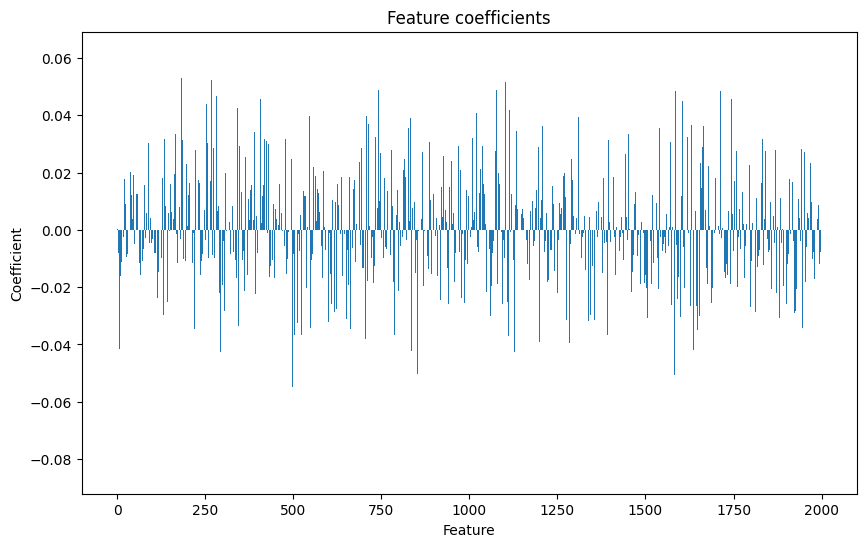

In [17]:
# get top and bottom 20 genes
sorted_genes = feature_coeffs.sort_values(by="coeff", ascending=False)
pos_genes = sorted_genes[:num_genes]
neg_genes = sorted_genes[-num_genes:]

gene_dict[dataset] = [pos_genes, neg_genes]
all_genes[dataset] = feature_coeffs
# print top 10 up and down coefficients
print(pos_genes.gene_names.values)
print(neg_genes.gene_names.values)


plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.title("Feature coefficients")
plt.show()

### Save the gene lists

In [21]:
# save the significant genes
for dataset in datasets[:2]:
    # save the significant genes
    significant_genes_list[dataset].to_csv(plot_outPath + f"significant_coef_genes_{dataset}.csv", index=False)

# save the top and lowest genes
for dataset in datasets:
    print(f"Dataset: {dataset}")
    gene_dict[dataset][0].to_csv(plot_outPath + f"top{num_genes}_genes_{dataset}.csv", index=False)
    gene_dict[dataset][1].to_csv(plot_outPath + f"bottom{num_genes}_genes_{dataset}.csv", index=False)



Dataset: OVA
Dataset: RBD
Dataset: OVA
Dataset: RBD
Dataset: INTEGRATED


#### Investigate overlap of the significant genes 

{'RPL35', 'RPS29', 'UBA52'}


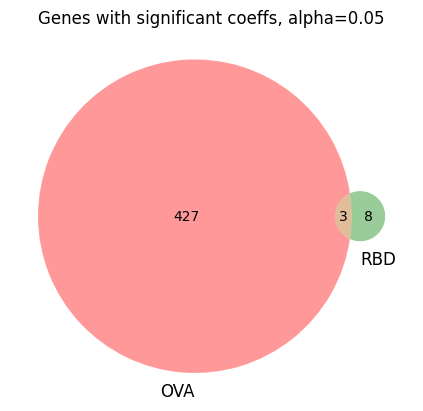

In [22]:
# Check overlap of the significant genes
overlap_genes = set(significant_genes_list["OVA"]["gene_names"]).intersection(
    set(significant_genes_list["RBD"]["gene_names"])
)
print(overlap_genes)


# venn plot of the number of genes that are in the top 50 of both datasets
plt.figure()
venn2(
    [
        set(significant_genes_list["OVA"].gene_names.values),
        set(significant_genes_list["RBD"].gene_names.values)
        # set(significant_genes_list["INTEGRATED"][0].gene_names.values),
    ],
    set_labels=("OVA", "RBD")
)
plt.title(f"Genes with significant coeffs, alpha=0.05")
plt.savefig(os.path.join(plot_outPath, "venn_sign_genes_OVA_RBD.png"), dpi=600)
plt.show()



#### Investigate overlap of top 50 genes 

Top 50 overlapping genes OBA & RBD {'TUBA1B', 'CHCHD2', 'UBA52', 'RPS29', 'PABPC1', 'ENO1B'}
Bottom 50 overlapping genes OBA & RBD {'MIF', 'EEF1G', 'TACSTD2', 'HSP90AB1'}


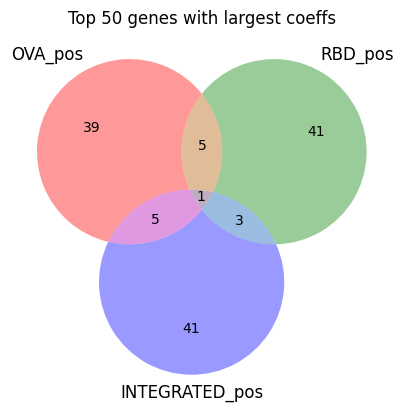

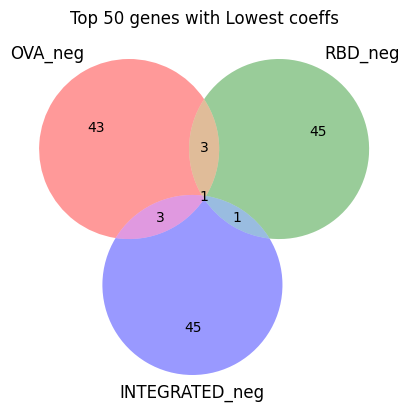

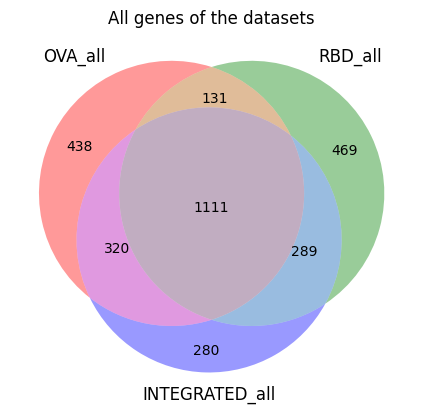

In [27]:
# print top overlapping genes
print("Top 50 overlapping genes OBA & RBD", 
    set(gene_dict["OVA"][0]["gene_names"]).intersection(
    set(gene_dict["RBD"][0]["gene_names"])
))

print("Bottom 50 overlapping genes OBA & RBD", 
    set(gene_dict["OVA"][1]["gene_names"]).intersection(
    set(gene_dict["RBD"][1]["gene_names"])
))

# venn plot of the number of genes that are in the top 50 of both datasets
plt.figure()
venn3(
    [
        set(gene_dict["OVA"][0].gene_names.values),
        set(gene_dict["RBD"][0].gene_names.values),
        set(gene_dict["INTEGRATED"][0].gene_names.values),
    ],
    set_labels=("OVA_pos", "RBD_pos", "INTEGRATED_pos"),
)
plt.title(f"Top {num_genes} genes with largest coeffs")
plt.savefig(os.path.join(plot_outPath, "venn_genes_pos.png"), dpi=600)
plt.show()

venn3(
    [
        set(gene_dict["OVA"][1].gene_names.values),
        set(gene_dict["RBD"][1].gene_names.values),
        set(gene_dict["INTEGRATED"][1].gene_names.values),
    ],
    set_labels=("OVA_neg", "RBD_neg", "INTEGRATED_neg"),
)
plt.title(f"Top {num_genes} genes with Lowest coeffs")
plt.savefig(os.path.join(plot_outPath, "venn_genes_neg.png"), dpi=600)
plt.show()


### Venn plot of all genes
plt.figure()
venn3(
    [
        set(all_genes["OVA"].gene_names.values),
        set(all_genes["RBD"].gene_names.values),
        set(all_genes["INTEGRATED"].gene_names.values),
    ],
    set_labels=("OVA_all", "RBD_all", "INTEGRATED_all"),
)
plt.title("All genes of the datasets")
plt.savefig(os.path.join(plot_outPath, "venn_all_genes.png"), dpi=600)
plt.show()

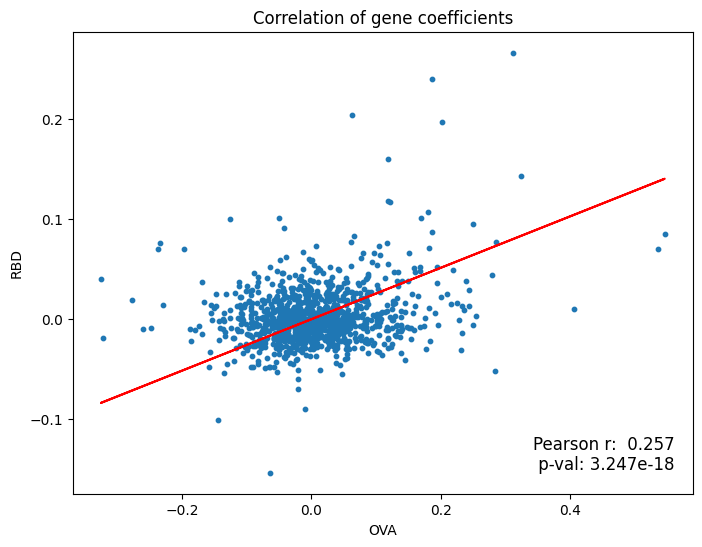

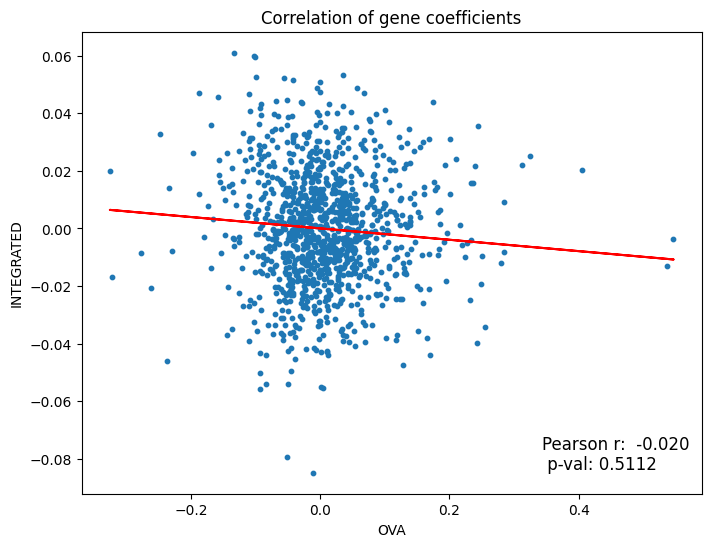

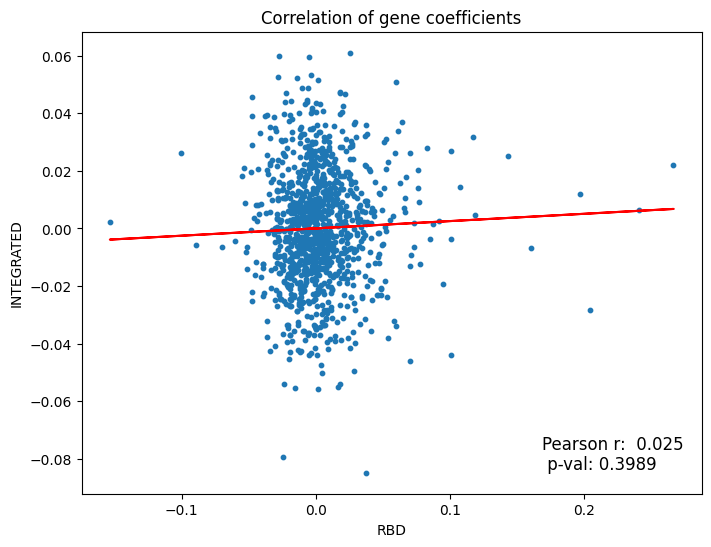

In [28]:
### plot correlation and pvalues of correlation of genes
from scipy.stats import pearsonr

# get intersection of all genes
common_genes1 = np.intersect1d(
    all_genes["OVA"].gene_names.values, all_genes["RBD"].gene_names.values
)
common_genes = np.intersect1d(common_genes1, all_genes["INTEGRATED"].gene_names.values)


# print(len(common_genes))
# print(all_genes['OVA'][all_genes['OVA'].gene_names.isin(common_genes)])



# plot correlation of the genes OVA/RBD
plot_correlation(
    vals1=all_genes["OVA"]["coeff"][all_genes["OVA"].gene_names.isin(common_genes)],
    vals2=all_genes["RBD"]["coeff"][all_genes["RBD"].gene_names.isin(common_genes)],
    datasets=["OVA", "RBD"],
    plot_outPath=plot_outPath,
)
plot_correlation(
    vals1=all_genes["OVA"]["coeff"][all_genes["OVA"].gene_names.isin(common_genes)],
    vals2=all_genes["INTEGRATED"]["coeff"][
        all_genes["INTEGRATED"].gene_names.isin(common_genes)
    ],
    datasets=["OVA", "INTEGRATED"],
    plot_outPath=plot_outPath,
)
plot_correlation(
    vals1=all_genes["RBD"]["coeff"][all_genes["RBD"].gene_names.isin(common_genes)],
    vals2=all_genes["INTEGRATED"]["coeff"][
        all_genes["INTEGRATED"].gene_names.isin(common_genes)
    ],
    datasets=["RBD", "INTEGRATED"],
    plot_outPath=plot_outPath,
)